# Question 2 Lasso vs. Ridge Regression

In [56]:
# Imports

import pandas as pd
import numpy as np
from typing import List
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [57]:
# Dataset (From Homework Description)

df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df_D = pd.concat([df['age_at_diagnosis'], df.iloc[:, 31:520]], axis=1)
D = df_D.to_numpy()
y = df['overall_survival_months'].to_numpy()
df_D

C:\Users\Maris\AppData\Local\Temp\ipykernel_17424\328118114.py:3: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC_RNA_Mutation.csv")


,age_at_diagnosis,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,75.65,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,43.19,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,48.87,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,47.68,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,76.97,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,43.10,0.1563,0.5543,-0.6149,0.4572,1.3822,-0.0537,-0.1323,0.2837,-0.0726,...,0.7859,1.5304,1.1196,0.8116,0.0958,-1.2644,-0.3566,-0.2615,-0.6371,-0.5540
1900,42.88,0.1343,0.9128,1.3017,0.7383,0.1841,0.0028,0.1243,2.2040,-0.6190,...,-0.5294,-0.6610,-0.1610,0.2251,0.5127,-0.3412,-1.0703,-0.6950,0.0641,-0.8863
1901,62.90,1.8107,-0.2608,0.4006,-0.2985,0.0356,-0.1620,1.5486,1.5309,-1.3653,...,-0.1457,-0.5194,2.3968,0.5917,-0.8643,-1.3541,-1.8076,-0.1840,0.0967,-0.6264
1902,61.16,-1.2746,-1.7695,-0.3454,-0.3850,0.6689,1.4531,1.0956,-0.0948,-0.6188,...,-0.6380,-1.5275,1.1070,0.2194,1.4317,-0.6985,-0.6046,-0.4915,-0.2847,-0.8041


## Ridge

In [58]:
def ridge(X, y, lam):
    n = X.shape[0]
    ones = np.ones((n, 1))
    X_augmented = np.hstack((ones, X))
    identity = np.eye(X_augmented.shape[1])
    y = np.asarray(y).reshape(-1, 1)
    beta = np.linalg.inv(X_augmented.T @ X_augmented / n + lam * identity) @ X_augmented.T @ y / n
    return beta

In [59]:
def cross_val_MSE(X, y, lamd):
    def nrof_features(beta):
        return np.count_nonzero(beta)

    def predicted_values(X, beta):
        return np.hstack((np.ones((np.asarray(X).shape[0],1)), np.asarray(X))).dot(beta)

    kf = KFold(n_splits=5, shuffle=True)
    
    mse_train = []
    mse_test = []
    features = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        beta = ridge(X_train, y_train, lamd)
        y_pred_train, y_pred_test = predicted_values(X_train, beta), predicted_values(X_test, beta)
        
        mse_train.append(mean_squared_error(y_train, y_pred_train))
        mse_test.append(mean_squared_error(y_test, y_pred_test))
        features.append(nrof_features(beta))
        
    return {'MSE_train': np.mean(mse_train), 'MSE_test': np.mean(mse_test), 'Avg_features': np.mean(features)}

In [60]:
rng = np.arange(10e-10, 9, 10e-2)
train = [cross_val_MSE(D, y, z)['MSE_train'] for z in rng]
test = [cross_val_MSE(D, y, z)['MSE_test'] for z in rng]

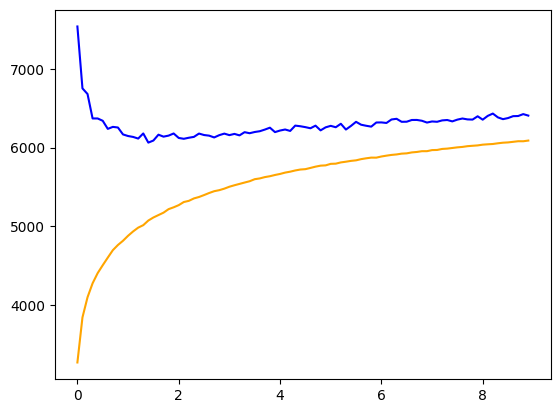

In [61]:
fig, ax = plt.subplots()
ax.plot(rng, test, label = 'MSE test', color = 'blue')
ax.plot(rng, train, label = 'MSE train', color = 'orange')
plt.show()

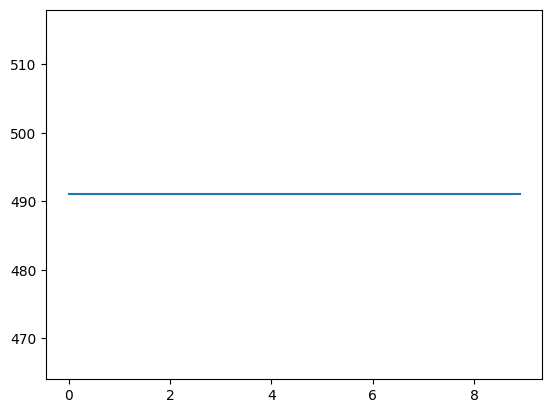

In [62]:
# Ridge
ft = [cross_val_MSE(D, y, z)['Avg_features'] for z in rng]
plt.plot(rng, ft, label = 'Avg features')
plt.show()

## Lasso

In [80]:
def lasso(X, y):
    def train_model(X_train, y_train):
        model = Lasso(alpha=a)
        model.fit(X_train, y_train)
        return model
    
    def predict(model, X_test):
        return model.predict(X_test)
    
    def compute_mse(y_true, y_pred):
        return mean_squared_error(y_true, y_pred)
    
    def compute_num_features(model):
        return np.sum(abs(model.coef_) > 1e-16)
    
    lamds = np.arange(10e-10, 9)
    mse_cv_train = []
    mse_cv_test = []
    num_selected_features = []
    kfold = KFold(n_splits=5,  shuffle=True)
    for a in lamds:
        MSE_train = []
        MSE_test = []
        features = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = train_model(X_train, y_train)
            y_pred_train = predict(model, X_train)
            y_pred_test = predict(model, X_test)
            mse_train = compute_mse(y_train, y_pred_train)
            MSE_train.append(mse_train)
            mse_test = compute_mse(y_test, y_pred_test)
            MSE_test.append(mse_test)
            nfeatures = compute_num_features(model)
            features.append(nfeatures)
        mse_cv_train.append(np.mean(MSE_train))
        mse_cv_test.append(np.mean(MSE_test))
        num_selected_features.append(np.mean(features))
    
    return lamds, mse_cv_train, mse_cv_test, num_selected_features

C:\Users\Maris\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.607e+06, tolerance: 8.947e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Maris\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+06, tolerance: 8.931e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Maris\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

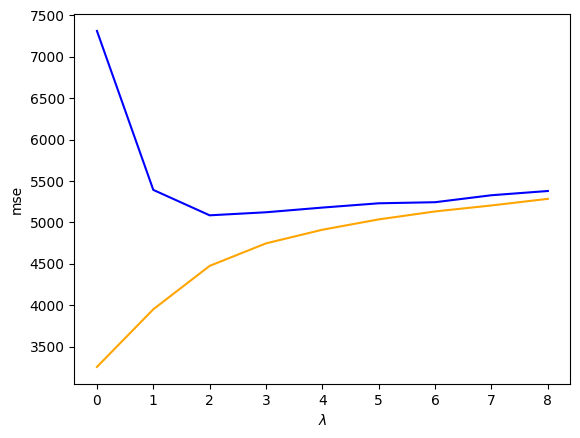

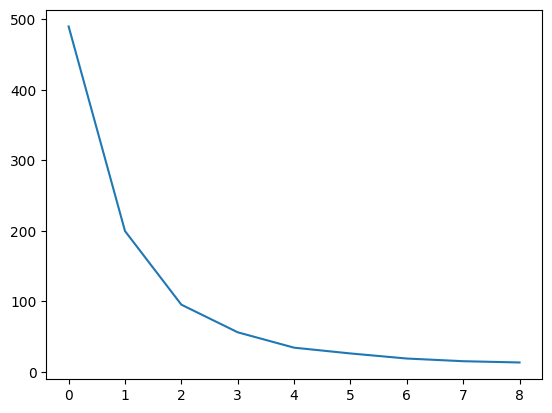

In [81]:
def plot_mse(lamds, mse_cv_train, mse_cv_test):
    fig, ax = plt.subplots()

    ax.plot(lamds, mse_cv_train, label='Train MSE', color='orange')
    ax.plot(lamds, mse_cv_test, label='Test MSE', color='blue')
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('mse')

def plot_num_features(lamds, num_selected_features):
    fig, ax = plt.subplots()

    ax.plot(lamds, num_selected_features, label='Avg Features')
    ax.set

lamds, mse_cv_train, mse_cv_test, num_selected_features = lasso_model(D, y)
plot_mse(lamds, mse_cv_train, mse_cv_test)
plot_num_features(lamds, num_selected_features)
plt.show()